## Object Detection - Tensorflow Models
- code reference taken from - https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model.html#sphx-glr-auto-examples-plot-object-detection-saved-model-py

In [1]:
#import statements
import numpy as np
from PIL import Image
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils



### Model Name List

In [2]:
model_name_list = [
    #('centernet_hg104_1024x1024_coco17_tpu-32', '20200713'),
    #('centernet_hg104_512x512_coco17_tpu-8', '20200711'),
    #('centernet_resnet50_v1_fpn_512x512_coco17_tpu-8', '20200711'),
    #('centernet_resnet50_v2_512x512_coco17_tpu-8', '20200711'),
    #('efficientdet_d0_coco17_tpu-32', '20200711'),
    ('ssd_mobilenet_v2_320x320_coco17_tpu-8', '20200711'),
    #('faster_rcnn_resnet50_v1_640x640_coco17_tpu-8', '20200711'),
    #('mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8', '20200711')
    #('extremenet', '20200711') some error here, seems like extremenet does not have saved model dir in c/users/shubham/keras
]

### Fetch Images for inferences

In [3]:
def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()

In [4]:
IMAGE_PATHS

['C:\\Users\\shubham\\.keras\\datasets\\image1.jpg',
 'C:\\Users\\shubham\\.keras\\datasets\\image2.jpg']

### Download the COCO Labels

In [5]:
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

In [6]:
PATH_TO_LABELS

'C:\\Users\\shubham\\.keras\\datasets\\mscoco_label_map.pbtxt'

### Load label map data (for plotting)

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

### Download model from tensorflow.org/models
- More models can be found in the TensorFlow 2 Detection Model Zoo. To use a different model you will need the URL name of the specific model. This can be done as follows:
1. Right click on the Model name of the model you would like to use;
2. Click on Copy link address to copy the download link of the model;
3. Paste the link in a text editor of your choice. You should observe a link similar to download.tensorflow.org/models/object_detection/tf2/YYYYYYYY/XXXXXXXXX.tar.gz;
4. Copy the XXXXXXXXX part of the link and use it to replace the value of the MODEL_NAME variable in the code shown below;
5. Copy the YYYYYYYY part of the link and use it to replace the value of the MODEL_DATE variable in the code shown below.

In [8]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

def download_models(model_name_list):
    model_dir_path_dict = {}
    for model_name in model_name_list:
        path = download_model(model_name[0], model_name[1])
        model_dir_path_dict[model_name[0]] = path
        print("downloaded {0}".format(model_name[0]))
    return model_dir_path_dict


#use below list to know model name and where it is downloaded locally
model_dir_path_dict = download_models(model_name_list)

downloaded ssd_mobilenet_v2_320x320_coco17_tpu-8


### Load the downloaded models from directories

In [9]:
def load_model(model_name, model_dir):
    print(model_dir)
    path_to_saved_model = model_dir + "/saved_model"

    print('Loading model...', end='')
    start_time = time.time()

    # Load saved model and build the detection function
    detect_fn = tf.saved_model.load(path_to_saved_model)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Done! Took {} seconds'.format(elapsed_time))
    return detect_fn



def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

def detect_objects(model):
    object_detections = []
    for image_path in IMAGE_PATHS:
        print('Running inference for {}... '.format(image_path), end='')
        
        # use Image.fromarray(image_np) for converting below numpy arr img to pil img
        image_np = load_image_into_numpy_array(image_path)
        
        pil_img = Image.fromarray(image_np)
        width, height = pil_img.size
        print("after load size ", end='')
        print(width, height)
        
        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
        input_tensor = tf.convert_to_tensor(image_np)
        # The model expects a batch of images, so add an axis with `tf.newaxis`.
        input_tensor = input_tensor[tf.newaxis, ...]

        # input_tensor = np.expand_dims(image_np, 0)
        detections = model(input_tensor)
        object_detections.append(detections)
    return object_detections

def process_detections(detections_list):
    result = []
    for detection in detections_list:
        num_detections = int(detection.pop('num_detections'))
        detection = {key: value[0, :num_detections].numpy()
                       for key, value in detection.items()}
        detection['num_detections'] = num_detections

        # detection_classes should be ints.
        detection['detection_classes'] = detection['detection_classes'].astype(np.int64)
        result.append(detection)
    return result

def visualise_results(detections, image_np, use_normalized_coordinates=True):
    # detections - single image detection result from a model, this detection object should be from the model inference result
    # image_np - numpy image
    # visualise single image results
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    # detection box - ymin, xmin, ymax, xmax
    # denormalise using - (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    image_np_with_detections = image_np.copy()
    
    pil_img = Image.fromarray(image_np_with_detections)
    width, height = pil_img.size
    print("before vis shape ", end='')
    print(width, height)
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=use_normalized_coordinates,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)
    
    #plt.figure()
    
    pil_img = Image.fromarray(image_np_with_detections)
    width, height = pil_img.size
    print("after vis shape ", end='')
    print(width, height)
    
    plt.imshow(image_np_with_detections)
    plt.show()

In [10]:
def run_inference(model_name, model_dir):
    model = load_model(model_name, model_dir)
    detections_list = detect_objects(model)
    detections_list = process_detections(detections_list)
    #process detections object to output list as per your need
    print("Model: {0}".format(model_name))
    return detections_list
    #visualise_results(detections)

In [11]:
detections = None
for model in model_dir_path_dict:
    detections = run_inference(model, model_dir_path_dict[model])

C:\Users\shubham\.keras\datasets\ssd_mobilenet_v2_320x320_coco17_tpu-8
Loading model...Done! Took 41.69941782951355 seconds
Running inference for C:\Users\shubham\.keras\datasets\image1.jpg... after load size 1024 636
Running inference for C:\Users\shubham\.keras\datasets\image2.jpg... after load size 1352 900
Model: ssd_mobilenet_v2_320x320_coco17_tpu-8


In [12]:
detection1 = detections[0]
detection2 = detections[1]

In [13]:
scores = detection1["detection_scores"]
scores = [score for score in scores if score > 0.5]
print(scores)

take = len(scores)

boxes = detection1["detection_boxes"]
boxes = boxes[: take]
print(boxes)

detected_classes = detection1["detection_classes"]
detected_classes = detected_classes[: take]
print(detected_classes)

def denormalise_boxes(boxes):
    #boxes - list of list
    # box - ymin, xmin, ymax, xmax
    orig_boxes = []
    for box in boxes:
        temp = []
        temp.append(box[0]*636)
        temp.append(box[1]*1024)
        temp.append(box[2]*636)
        temp.append(box[3]*1024)
        orig_boxes.append(temp)
    return np.array(orig_boxes)

print("----------------------------")
detection1_norm = {}
detection1_norm["detection_scores"] = scores
detection1_norm["detection_boxes"] = boxes
detection1_norm["detection_classes"] = detected_classes
print(detection1_norm)

print("----------------------------")
detection1_denorm = {}
detection1_denorm["detection_scores"] = scores
detection1_denorm["detection_boxes"] = denormalise_boxes(boxes)
detection1_denorm["detection_classes"] = detected_classes
print(detection1_denorm)

[0.813294, 0.7466741, 0.54327905]
[[0.12570798 0.36762646 0.97101545 0.9804251 ]
 [0.03409877 0.01441482 0.85965204 0.30994383]
 [0.         0.5301741  0.2794348  0.7160459 ]]
[18 18  1]
----------------------------
{'detection_scores': [0.813294, 0.7466741, 0.54327905], 'detection_boxes': array([[0.12570798, 0.36762646, 0.97101545, 0.9804251 ],
       [0.03409877, 0.01441482, 0.85965204, 0.30994383],
       [0.        , 0.5301741 , 0.2794348 , 0.7160459 ]], dtype=float32), 'detection_classes': array([18, 18,  1], dtype=int64)}
----------------------------
{'detection_scores': [0.813294, 0.7466741, 0.54327905], 'detection_boxes': array([[  79.95027781,  376.44949341,  617.56582832, 1003.95532227],
       [  21.68682039,   14.76077271,  546.73869896,  317.38247681],
       [   0.        ,  542.89825439,  177.72053289,  733.23101807]]), 'detection_classes': array([18, 18,  1], dtype=int64)}


In [15]:
img1_path = "C:\\Users\\shubham\\.keras\\datasets\\image1.jpg"
img1_arr = load_image_into_numpy_array(img1_path)
print(img1_arr.shape)
img1_pil = Image.fromarray(img1_arr)
width, height = img1_pil.size
print(width, height)

(636, 1024, 3)
1024 636


before vis shape 1024 636
after vis shape 1024 636


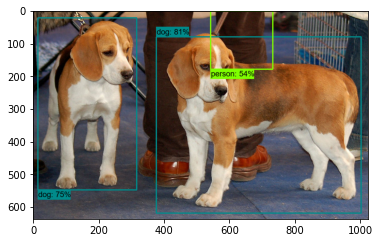

In [16]:
arr = []
%matplotlib inline
for image_path in IMAGE_PATHS:
    arr.append(load_image_into_numpy_array(image_path))

visualise_results(detection1_norm, arr[0])

before vis shape 1024 636
after vis shape 1024 636


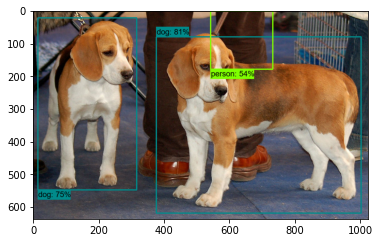

In [17]:
visualise_results(detection1_denorm, arr[0], False)